In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import os.path as osp
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

%matplotlib inline

In [2]:
base_path = '/lfs/local/0/nomir/learning-subspaces/learning-subspaces-results/cifar/eval-one-dimensional-subspaces'
fig_path = '/lfs/local/0/nomir/learning-subspaces/fig'
files = np.array(os.listdir(base_path))

## Stochastic Analysis

In [3]:
files = files[np.vectorize(lambda s: s.endswith('.pkl'))(files)]
# Filter out for only stochastic or baseline experiments
files = files[np.flatnonzero((np.core.defchararray.find(files,'stochastic') != -1) | 
                             (np.core.defchararray.find(files,'default')!=-1)
                            )]
# Filter for results found through hyperparameter search
files = files[np.flatnonzero((np.core.defchararray.find(files, 'epochs') != -1))]
print(f'Found {len(files)} files')

Found 556 files


In [4]:
data = []
default_vals = {'optimizer': 'sgd', 'epoch': 160, 'lr': 0.1}
for filename in tqdm(files):
    with open(osp.join(base_path, filename), 'rb') as file:
        file_data = np.vectorize(lambda s: s.split('=')[1])(filename.split('+'))
        # in case we're using a file from before hyperparam search, we need to add the default values
        # if 'optimizer' not in filename:
        #     print(file_data)
        file_data[-1] = file_data[-1][0]
        pickle_data = pickle.load(file)
        test_sensitivity = pickle_data['test_sensitivity']
        test_specificity = pickle_data['test_specificity']
        test_acc = pickle_data['test_acc']
        file_data = np.concatenate((file_data, test_acc, test_sensitivity, test_specificity), axis=None)
        data.append(file_data)

100%|█████████████████████████████████████████████████████████████████████████████| 556/556 [00:00<00:00, 6985.73it/s]


In [5]:
column_names = np.vectorize(lambda s: s.split('=')[0])(files[0].split('+')).tolist()
df = pd.DataFrame(data, columns=column_names + ['Test acc', 'Test sensitivity', 'Test specificity'])
df = df.astype({
    'lr': float, 
    'epochs': int, 
    'alpha0': float, 
    'alpha1': float, 
    'try': int, 
    'num_samples': int, 
    'seed': int
})
df = df.astype({'Test acc': float, 'Test sensitivity': float, 'Test specificity': float})
df = df[df['try'] == 0]

In [6]:
df_unmelt = df.copy()
df = df.melt(id_vars=column_names, var_name='Type', value_name='value')

In [7]:
# Add legible labels for experiments
experiment_to_label = {
    'default': 'Standard training with threshold',
    'default_stochastic': 'Single model with expectation loss',
    'weighted_default': 'Standard training with fixed tradeoff',
    'weighted_default_warm': 'Standard training with fixed tradeoff -- warm start',
    'lines_stochastic': 'Two objective linear subspace',
    'lines_stochastic_warm': 'Two objective linear subspace -- warm start',
    'curves_stochastic': 'Two objective Bezier curve subspace'
}

In [9]:
df['epochs'].unique()

array([320, 160])

In [67]:
df['id'].unique()

array(['default_stochastic', 'lines_stochastic', 'default',
       'weighted_default'], dtype=object)

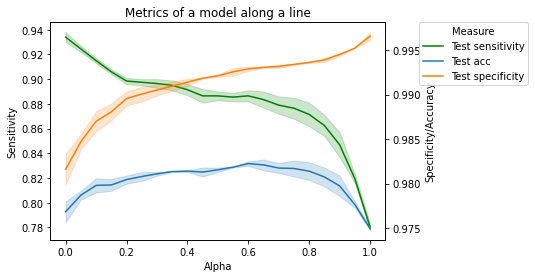

<Figure size 432x288 with 0 Axes>

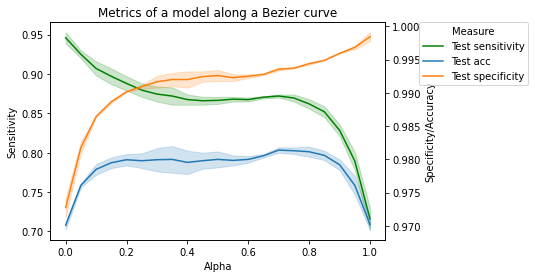

<Figure size 432x288 with 0 Axes>

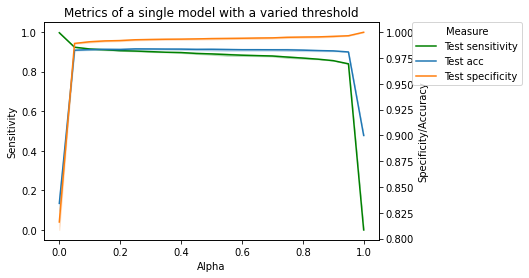

<Figure size 432x288 with 0 Axes>

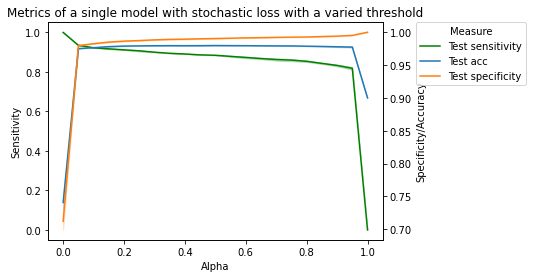

<Figure size 432x288 with 0 Axes>

In [8]:
subspaces = ['lines_stochastic', 
             'curves_stochastic', 
             'default',
             'default_stochastic',
             # 'weighted_default'
            ]
graph_titles = ['Metrics of a model along a line', 
                'Metrics of a model along a Bezier curve', 
                'Metrics of a single model with a varied threshold',
                'Metrics of a single model with stochastic loss with a varied threshold',
                # 'Metrics of models trained with weighted cross entropy'
               ]
for subspace, title in zip(subspaces, graph_titles):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    df_specific = df[df['id']==subspace]
    fig = sns.lineplot(data=df_specific[df_specific['Type'] == 'Test sensitivity'], x='alpha1', y='accuracy', hue='Type', ax=ax, palette=['green'])
    ax.set(ylabel='Sensitivity', xlabel='Alpha')
    ax2 = ax.twinx()
    fig2 = sns.lineplot(data=df_specific[(df_specific['Type'] == 'Test acc') | (df_specific['Type'] == 'Test specificity')], x='alpha1', y='accuracy', hue='Type', ax=ax2)
    ax2.set(ylabel='Specificity/Accuracy')
    # ax2.set(ylim=[0.95,1])
    fig.set_title(title)
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend([],[], frameon=False)
    ax2.legend(lines + lines2, labels + labels2, title='Measure', bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
    # plt.legend(title='Measure', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    fig.get_figure().savefig(osp.join(base_path, f'{subspace}_class-accuracy_v_alpha.pdf'), bbox_inches='tight')
    plt.clf()

## Comparing baselines and stochastic experiments

## comparing default training and stochastic loss training on single models

### All information on one graph

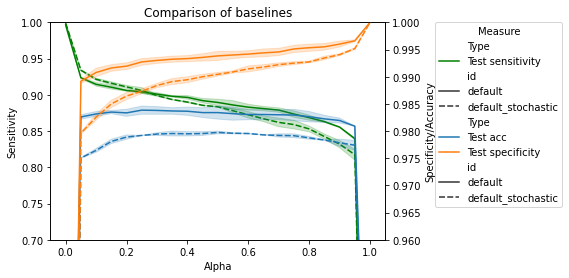

<Figure size 432x288 with 0 Axes>

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

df_specific = df[df['id'].str.contains('default')]
fig = sns.lineplot(data=df_specific[df_specific['Type'] == 'Test sensitivity'], x='alpha1', y='accuracy', hue='Type', style='id', ax=ax, palette=['green'])
ax.set(ylabel='Sensitivity', xlabel='Alpha')
ax.set(ylim=[0.7,1])
ax2 = ax.twinx()
fig2 = sns.lineplot(data=df_specific[(df_specific['Type'] == 'Test acc') | (df_specific['Type'] == 'Test specificity')], x='alpha1', y='accuracy', hue='Type', style='id', ax=ax2)
ax2.set(ylabel='Specificity/Accuracy')
ax2.set(ylim=[0.96,1])
fig.set_title('Comparison of baselines')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend([],[], frameon=False)
ax2.legend(lines + lines2, labels + labels2, title='Measure', bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
# plt.legend(title='Measure', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
fig.get_figure().savefig(osp.join(base_path, f'baseline-comparisom_metrics_v_alpha.pdf'), bbox_inches='tight')
plt.clf()

### Separate graphs for sensitivity, specificity, and accuracy

### Attempted hyperparam search

['sgd' 'AdamW'] [0.1] [320] [0 1]


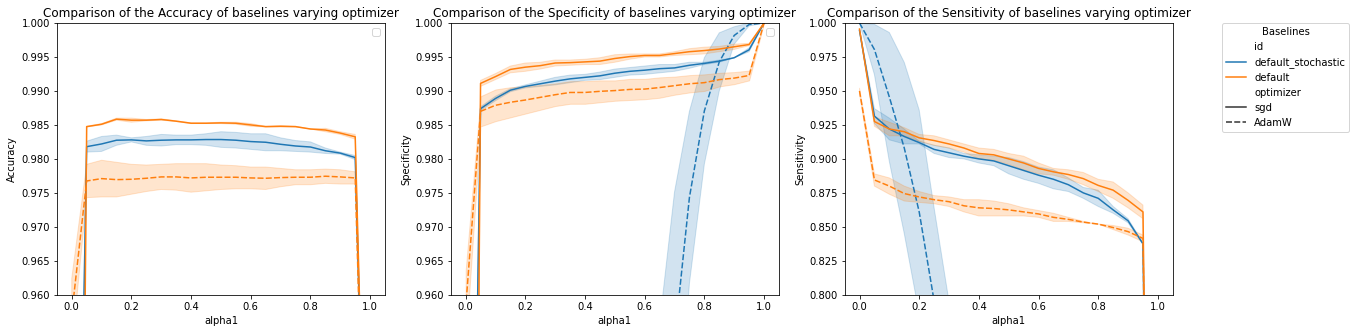

['sgd'] [0.1  0.05] [320] [0 1]


<Figure size 432x288 with 0 Axes>

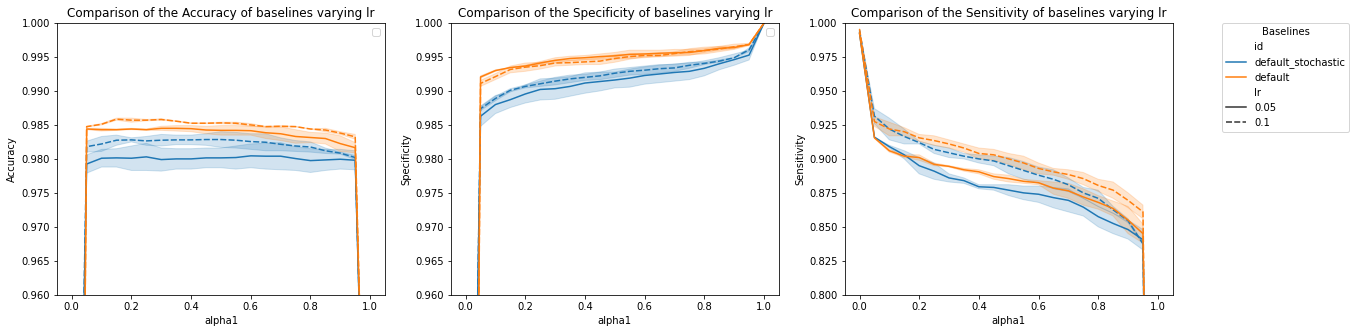

['sgd'] [0.1] [320 160] [0 1]


<Figure size 432x288 with 0 Axes>

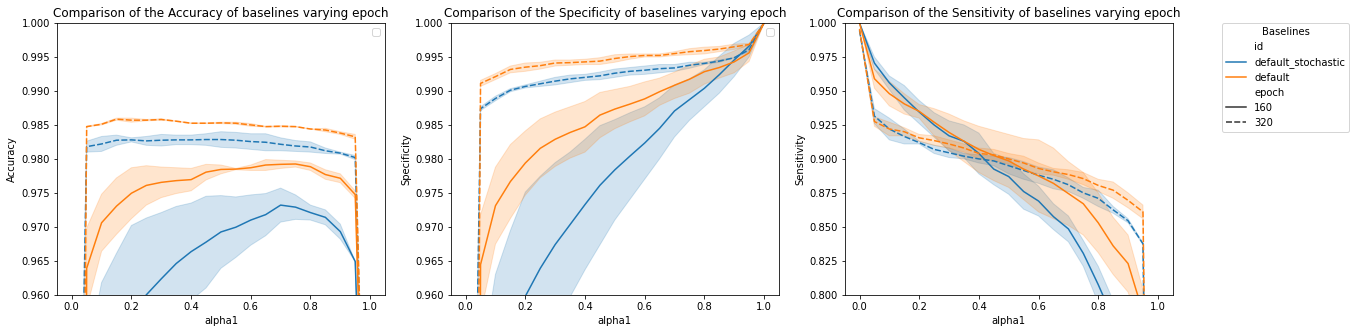

<Figure size 432x288 with 0 Axes>

In [91]:
df_specific = df[df['id'].str.contains('default')]
metric_types = ['Test acc', 'Test specificity', 'Test sensitivity']
metric_names = ['Accuracy', 'Specificity', 'Sensitivity']
ylims = [[0.96,1],[0.96,1],[0.8,1]]
defaults = {'optimizer': 'sgd', 'lr': 0.1, 'epoch': 320}
for hyperparam in ['optimizer', 'lr', 'epoch']:
    # get defaults for everything except what we care about
    df_default_but_one = df_specific.copy()
    for default_hyperparam in defaults:
        if default_hyperparam != hyperparam:
            df_default_but_one = df_default_but_one[df_default_but_one[default_hyperparam] == defaults[default_hyperparam]]
    fig, axes = plt.subplots(1, 3, figsize=(20,5), sharex=True)
    print(df_default_but_one['optimizer'].unique(), df_default_but_one['lr'].unique(), df_default_but_one['epoch'].unique(), df_default_but_one['seed'].unique())
    for i, (metric_type, metric_name, ylim) in enumerate(zip(metric_types, metric_names, ylims)):
        ax = axes[i]
        sns.lineplot(
            data=df_default_but_one[df_default_but_one['Type'] == metric_type], 
            x='alpha1', 
            y='accuracy', 
            hue='id', 
            style=hyperparam, 
            ax=ax
        )
        ax.set(title=f'Comparison of the {metric_name} of baselines varying {hyperparam}')
        ax.set(ylim=ylim, ylabel=metric_name)
        ax.legend([],[])
        # fig.get_figure().savefig(osp.join(base_path, f'baseline-comparison_{metric_name}_v_alpha.pdf'), bbox_inches='tight')
        if i % 3 == 2:
            axes[i].legend(title='Baselines', bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.clf()

### Baselines comparison

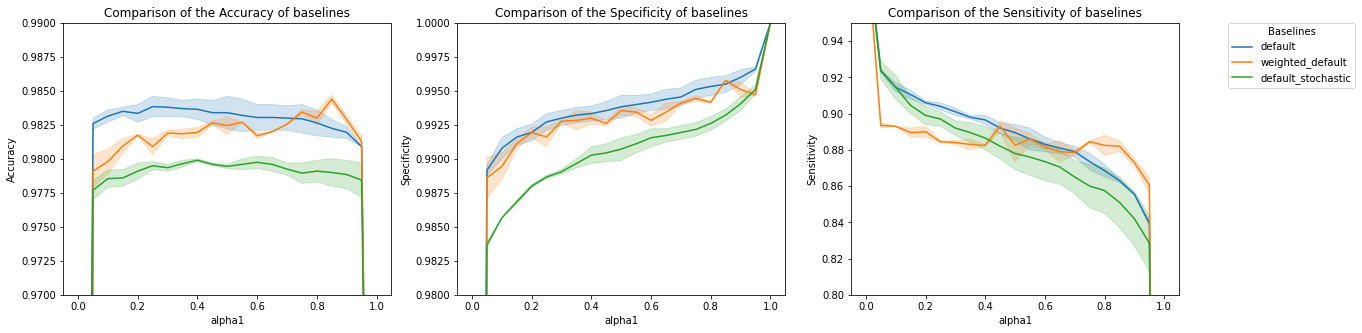

In [23]:
df_specific = df[(df['id'].str.contains('default'))]
fig, axes = plt.subplots(1, 3, figsize=(20,5), sharex=True)
metric_types = ['Test acc', 'Test specificity', 'Test sensitivity']
metric_names = ['Accuracy', 'Specificity', 'Sensitivity']
y_lims = [[0.97,0.99],[0.98,1],[0.8,0.95]]
for i, (metric_type, metric_name, ylim) in enumerate(zip(metric_types, metric_names, y_lims)):
    ax = axes[i]
    sns.lineplot(data=df_specific[df_specific['Type'] == metric_type], x='alpha1', y='accuracy', hue='id', ax=ax)
    ax.set(title=f'Comparison of the {metric_name} of baselines')
    ax.set(ylim=ylim, ylabel=metric_name)
    ax.legend([], [], frameon=False)
axes[-1].legend(title='Baselines', bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
plt.show()
fig.get_figure().savefig(osp.join(base_path, f'baseline_comparison_metrics_v_alpha.pdf'), bbox_inches='tight')

## comparing stochastic loss training on single model and subspace

### All information on one graph

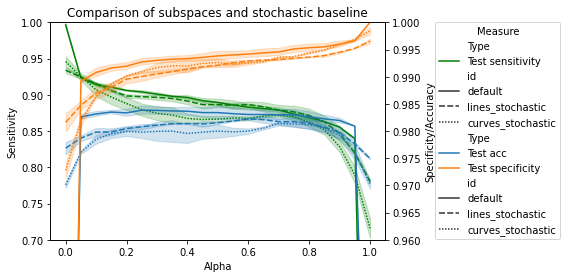

<Figure size 432x288 with 0 Axes>

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
df_specific = df[(df['id'].str.fullmatch('default')) | (df['id'].str.contains('lines_stochastic')) | (df['id'].str.contains('curves_stochastic'))]

fig = sns.lineplot(data=df_specific[df_specific['Type'] == 'Test sensitivity'], x='alpha1', y='accuracy', hue='Type', style='id', ax=ax, palette=['green'])
ax.set(ylabel='Sensitivity', xlabel='Alpha')
ax.set(ylim=[0.7,1])
ax2 = ax.twinx()
fig2 = sns.lineplot(data=df_specific[(df_specific['Type'] == 'Test acc') | (df_specific['Type'] == 'Test specificity')], x='alpha1', y='accuracy', hue='Type', style='id', ax=ax2)
ax2.set(ylabel='Specificity/Accuracy')
ax2.set(ylim=[0.96,1])
fig.set_title('Comparison of subspaces and stochastic baseline')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend([],[], frameon=False)
ax2.legend(lines + lines2, labels + labels2, title='Measure', bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
# plt.legend(title='Measure', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
fig.get_figure().savefig(osp.join(base_path, f'subspace-and-stochastic-baseline_metrics_v_alpha.pdf'), bbox_inches='tight')
plt.clf()

### information on separate graphs

In [12]:
df['id'].unique(), df['epochs'].unique(), df['lr'].unique()

(array(['default_stochastic', 'lines_stochastic_warm', 'lines_stochastic',
        'default', 'weighted_default', 'weighted_default_warm'],
       dtype=object),
 array([320,  80, 160,  40]),
 array([0.1, 0.2]))

In [26]:
df_specific = df[
    (df['id'].str.fullmatch('weighted_default') & (df['epochs'] == 160)) |
    (df['id'].str.fullmatch('default') & (df['epochs'] == 160)) |
    (df['id'].str.fullmatch('lines_stochastic') & (df['epochs'] == 160))
    # df['id'].str.fullmatch('lines_stochastic_warm')
]
df_specific['lr'].unique()

array([0.2, 0.1])

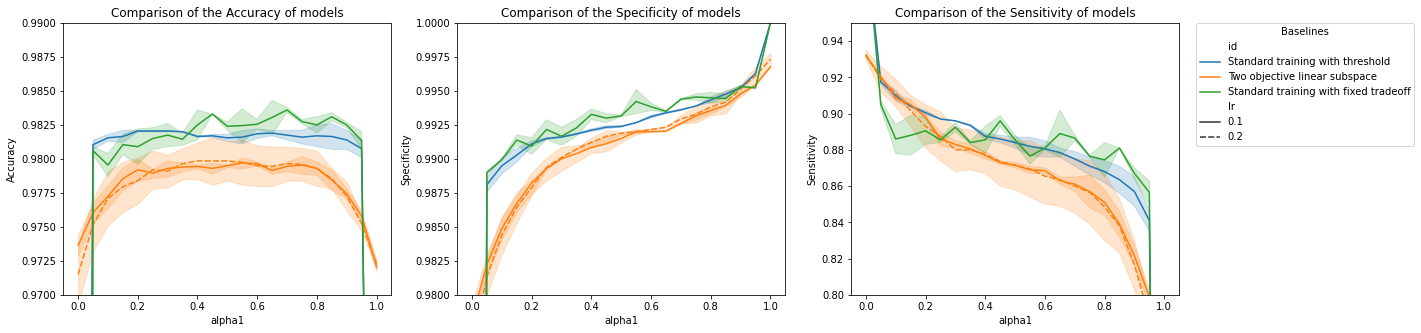

In [30]:
# df_specific = df[(df['id'].str.fullmatch('weighted_default')) | (df['id'].str.fullmatch('default')) | (df['id'].str.contains('lines_stochastic'))]
# df_specific = df_specific[df_specific['epochs'] == 160]
# df_specific = df[(
#     ((df['epochs'] == 320) & (df['id'] == 'lines_stochastic')) | 
#     ((df['epochs'] == 160) & df['id'].str.fullmatch('weighted_default|default'))
# )]
df_specific = df[
    (df['id'].str.fullmatch('weighted_default') & (df['epochs'] == 160)) |
    (df['id'].str.fullmatch('default') & (df['epochs'] == 160)) |
    (df['id'].str.fullmatch('lines_stochastic') & (df['epochs'] == 160))
    # df['id'].str.fullmatch('lines_stochastic_warm')
]

fig, axes = plt.subplots(1, 3, figsize=(20,5), sharex=True)
metric_types = ['Test acc', 'Test specificity', 'Test sensitivity']
metric_names = ['Accuracy', 'Specificity', 'Sensitivity']
y_lims = [[0.97,0.99],[0.98,1],[0.8,0.95]]
hue_order = ['default', 'lines_stochastic','weighted_default']
# style_order = [160, 40, 80]
style_order = [0.1, 0.2]

for i, (metric_type, metric_name, ylim) in enumerate(zip(metric_types, metric_names, y_lims)):
    ax = axes[i]
    sns.lineplot(data=df_specific[df_specific['Type'] == metric_type], x='alpha1', y='value', hue='id', style='lr', 
                 ax=ax, hue_order=hue_order, style_order=style_order)
    ax.set(title=f'Comparison of the {metric_name} of models')
    ax.set(ylim=ylim, ylabel=metric_name)
    ax.legend([], [], frameon=False)
    # for line in ax.lines:
    #     line.set_linestyle('--')

handles, labels = ax.get_legend_handles_labels()
labels = pd.DataFrame(labels).replace(experiment_to_label)[0].to_list()
ax.legend(handles, labels, title='Baselines', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.get_figure().savefig(osp.join(fig_path, f'subspace-and-stochastic-baseline_various_lr_metrics.pdf'), bbox_inches='tight')
plt.show()

In [33]:
pd.DataFrame(axes[-1].get_legend_handles_labels()[1]).replace(experiment_to_label)[0].to_list()

['id',
 'Two objective linear subspace',
 'Standard training with threshold',
 'Standard training with fixed tradeoff',
 'epochs',
 '160',
 '320']

## ROC Curve

In [15]:
df_specific = df_unmelt[
    df_unmelt['id'].str.fullmatch('weighted_default') |
    df_unmelt['id'].str.fullmatch('default') |
    df_unmelt['id'].str.fullmatch('lines_stochastic_warm')
]

df_specific['epochs'].unique(), df_specific['lr'].unique()

(array([ 80,  40, 160, 320]), array([0.1]))

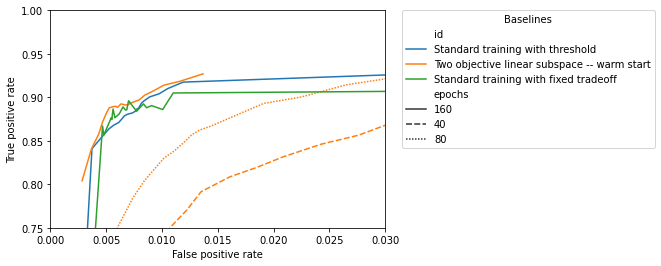

In [8]:
# df_specific = df_unmelt[(df_unmelt['id'].str.fullmatch('weighted_default')) | (df_unmelt['id'].str.fullmatch('default')) | (df_unmelt['id'].str.contains('lines_stochastic'))]
# df_specific = df_specific[df_specific['epochs'] == 160]
# df_specific = df_specific[df_specific['seed'] == 1]

df_specific = df_unmelt.groupby(['id', 'optimizer', 'lr', 'epochs', 'alpha0', 'alpha1']).mean().reset_index()

df_specific = df_specific[
    (df_specific['id'].str.fullmatch('weighted_default') & (df_specific['epochs'] == 160)) |
    (df_specific['id'].str.fullmatch('default') & (df_specific['epochs'] == 160)) |
    # (df_specific['id'].str.fullmatch('lines_stochastic') & (df_specific['epochs'] == 320)) |
    df_specific['id'].str.fullmatch('lines_stochastic_warm')
]

hue_order = ['default', 'lines_stochastic_warm','weighted_default']
style_order = [160, 40, 80]
# df_specific = df_unmelt[(
#     ((df_unmelt['epochs'] == 320) & (df_unmelt['id'] == 'lines_stochastic')) | 
#     ((df_unmelt['epochs'] == 160) & df_unmelt['id'].str.fullmatch('weighted_default|default'))
# )]
df_specific['False positive rate'] = 1 - df_specific['Test specificity']
df_specific['True positive rate'] = df_specific['Test sensitivity']
# df_specific = df_specific[['id', 'False positive rate', 'True positive rate', 'epochs']]
ax = sns.lineplot(data=df_specific, x='False positive rate', y='True positive rate', hue='id', style='epochs', hue_order=hue_order, style_order=style_order, ci=None)
ax.set(xlim=[0,0.03], ylim=[0.75,1])
handles, labels = ax.get_legend_handles_labels()
labels = pd.DataFrame(labels).replace(experiment_to_label)[0].to_list()
ax.legend(handles, labels, title='Baselines', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(osp.join(fig_path, f'subspace-and-stochastic-baseline_warm-start-various-epochs_ROC.pdf'), bbox_inches='tight')

## Random util scripts

In [58]:
# Renaming badly named files
for filename in files:
    if 'epochsalpha' in filename:
        new_name = 'alpha'.join(filename.split('epochsalpha'))
        print(f'Renaming {filename} to\n{new_name}')
        os.rename(osp.join(base_path, filename), osp.join(base_path, new_name))
    # In this case have to remove the redundant epoch 
    elif filename.find('epoch') != filename.rfind('epoch'):
        epoch_split_idx = filename.rfind('epoch')
        second_half_name = filename[epoch_split_idx:]
        second_half_new_name = second_half_name[second_half_name.find('+') + 1:]
        new_name = filename[:epoch_split_idx] + second_half_new_name
        print(f'Renaming {filename} to\n{new_name}')
        os.rename(osp.join(base_path, filename), osp.join(base_path, new_name))

Renaming id=default+ln=0.0+num_samples=1+optimizer=sgd+lr=0.1+epochs=320+seed=1+epoch=0+alpha0=0.3+alpha1=0.7+try=0_metrics.pkl to
id=default+ln=0.0+num_samples=1+optimizer=sgd+lr=0.1+epochs=320+seed=1+alpha0=0.3+alpha1=0.7+try=0_metrics.pkl
Renaming id=weighted_default+ln=0.0+num_samples=1+optimizer=sgd+lr=0.1+epochs=160+seed=1+epochsalpha0=0.2+alpha1=0.8+try=0_metrics.pkl to
id=weighted_default+ln=0.0+num_samples=1+optimizer=sgd+lr=0.1+epochs=160+seed=1+alpha0=0.2+alpha1=0.8+try=0_metrics.pkl
Renaming id=lines_stochastic+ln=0.0+num_samples=1+optimizer=sgd+lr=0.1+epochs=160+seed=0+epoch=0+alpha0=0.75+alpha1=0.25+try=0_metrics.pkl to
id=lines_stochastic+ln=0.0+num_samples=1+optimizer=sgd+lr=0.1+epochs=160+seed=0+alpha0=0.75+alpha1=0.25+try=0_metrics.pkl
Renaming id=lines_stochastic+ln=0.0+num_samples=1+optimizer=sgd+lr=0.1+epochs=160+seed=0+epoch=0+alpha0=0.9+alpha1=0.09999999999999998+try=0_metrics.pkl to
id=lines_stochastic+ln=0.0+num_samples=1+optimizer=sgd+lr=0.1+epochs=160+seed=0+

In [ ]:
# Renaming badly named files
for filename in files:
    if "weighted_default_warm" in filename:
        files = 
